In [7]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [2]:
info_data_path = "../data/raw_data/data.info"
with open(info_data_path, 'r') as f:
    info = f.read().splitlines()

info_list = [info[i].split(",") for i in range(len(info))]
info_df = pd.DataFrame(info_list[1:]) 
info_df.columns = info_list[0]

In [3]:
info_df["transcript_position"] = info_df["transcript_position"].astype(str).astype(int)

In [4]:
A549_rep5_run1 = pd.read_csv("../data/aws_predictions/A549_rep5_run1_prediction.csv")
A549_rep6_run1 = pd.read_csv("../data/aws_predictions/A549_rep6_run1_prediction.csv")

In [8]:
A549_rep5_run1["label"] = A549_rep5_run1.score.map(lambda x:1 if x>=0.35 else 0)
A549_rep6_run1["label"] = A549_rep6_run1.score.map(lambda x:1 if x>=0.35 else 0)

In [13]:
merge1 = A549_rep5_run1.merge(A549_rep6_run1, on = ['transcript','position'],how='inner')

In [15]:
merge1['new'] = np.where((merge1['label_x'] == merge1['label_y']), True, False)

In [16]:
merged_d0 = merge1.merge(info_df, how = "left", left_on = ["transcript", "position"], right_on = ["transcript_id", "transcript_position"])
merged_d0 = merged_d0.drop(["transcript_id", "transcript_position"], axis = 1)
merged_d0.label= merged_d0.label.astype(int)

In [17]:
merged_d0['x_actual'] = np.where((merged_d0['label_x'] == merged_d0['label']), True, False)
merged_d0['y_actual'] = np.where((merged_d0['label_y'] == merged_d0['label']), True, False)

In [18]:
merged_d0['mean_scores'] = merged_d0[['score_x', 'score_y']].mean(axis=1)
merged_d0["pred_mean"] = merged_d0.mean_scores.map(lambda x:1 if x>=0.35 else 0)

In [19]:
merged_d0['mean_actual'] = np.where((merged_d0['pred_mean'] == merged_d0['label']), True, False)

In [20]:
ind = ind = ["rep_5", "rep_6", "mean"]
rep5_count = list(merged_d0["x_actual"].value_counts())
rep6_count = list(merged_d0["y_actual"].value_counts())
mean_count = list(merged_d0["mean_actual"].value_counts())

In [21]:
df = pd.DataFrame([rep5_count[0], rep6_count[0], mean_count[0]], columns = ["True"], index = ind)
df["False"] = [rep5_count[1], rep6_count[1], mean_count[1]]
df = df.transpose()

Text(0.5, 1.0, 'A549 Cancer Cell Line')

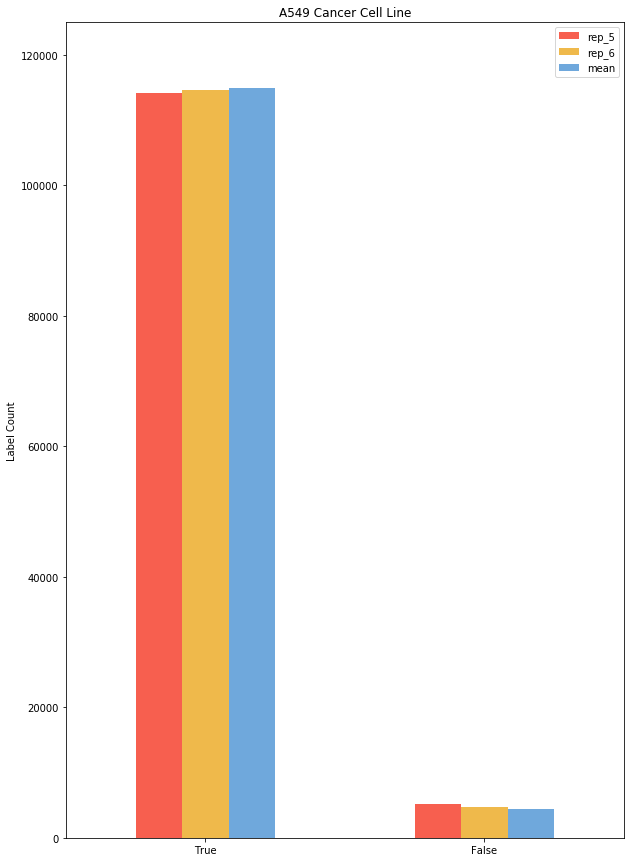

In [23]:
from turtle import width

colour_scheme = {"rep_5": "#f75f4f", "rep_6": "#efb94b",  "mean": "#6fa8dc"}
df.plot(kind = "bar", figsize = (10, 15), color = colour_scheme)

plt.ylabel("Label Count")
plt.ylim([0, 125000])
plt.gca().xaxis.set_tick_params(rotation = 0)
plt.title("A549 Cancer Cell Line")

In [24]:
merged_d0.head()

,transcript,position,score_x,label_x,score_y,label_y,new,gene_id,label,x_actual,y_actual,mean_scores,pred_mean,mean_actual
0,ENST00000373020,1006,0.004545,0,0.031818,0,True,ENSG00000000003,0,True,True,0.018182,0,True
1,ENST00000373020,1013,0.009091,0,0.009091,0,True,ENSG00000000003,0,True,True,0.009091,0,True
2,ENST00000373020,1149,0.004545,0,0.000000,0,True,ENSG00000000003,0,True,True,0.002273,0,True
3,ENST00000373020,512,0.013636,0,0.036364,0,True,ENSG00000000003,0,True,True,0.025000,0,True
4,ENST00000373020,689,0.004545,0,0.027273,0,True,ENSG00000000003,0,True,True,0.015909,0,True


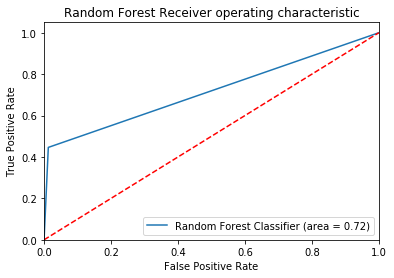

In [26]:
## define roc metrics
y_pred = merged_d0.pred_mean
y_test = merged_d0.label.astype(int)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

## plot roc curve
plt.figure()
plt.plot(fpr, tpr, label = 'Random Forest Classifier (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Receiver operating characteristic')
plt.legend(loc = "lower right")
plt.show()